
# RSCAM Computer Assessment 1


In this assessment you will use Python to solve some ordinary differential equations, to compute solutions numerically using discretization methods, to graph their solutions and to explore the behavior of differential equations and discretizations under changes in parameters.


In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import multiprocessing as mp 
import time

# Comparing Euler and Leapfrog Methods on the Trimer
Euler's method computes an approximate trajectory of a differential equation.  We can easily compute numerical solutions using Euler's method for any differential equation.  If we do this for several different stepsizes, we get different discrete approximations to the solution trajectory.  Another numerical method, which is particular good for conservative systems, is the leapfrog scheme.   Here you will compare the two methods by implementing them and simulating the dynamics of a simple model, the Lennard-Jones trimer.

## The Lennard-Jones Trimer
The LJ trimer is a model for a system of three atoms interacting through a pairwise Lennard-Jones potential. 
$$
\varphi_{\rm LJ}(r) = r^{-12} - r^{-6}.
$$
By considering special 'isosceles' configurations of the three atoms, we can simplify the equations for the LJ Trimer to a model with just two degrees of freedom, as mentioned in the slides of Lecture 1.

The Hamiltonian is then
$$ H = \frac{p_x^2}{4} + \frac{9p_y^2}{4} + 2\varphi_{\rm LJ}\left (\sqrt{x^2+y^2}\right ) + \varphi_{\rm LJ}(2x)$$.
The kinetic energy is $$K(p) = \frac{p_x^2}{4} + \frac{9p_y^2}{4}$$.   This is in the form $K(p) = p^T M^{-1} p/2$ where the mass matrix is $$M = {\rm diag}(2, 2/9)$$.   The potential energy function is $$U(q) = 2\varphi_{\rm LJ}\left (\sqrt{x^2+y^2} \right ) + \varphi_{\rm LJ}\left (2x \right)$$.

Write out and then code the equations of motion of the trimer from the Hamiltonian.  In Python there is a distinction between row and column vectors.  We will use column vectors.   Let $q = [x, y]^T$ and $p=[p_x, p_y]^T$.  You will need to code a small function to compute the force which is the **negative gradient** of the potential energy function.  The input of the force function is a 2d column vector q and the output is a 2d column vector F.  A template is provided below for you to fill in.

In [14]:
def phi_lj(r):
    return (r**(-12)) - (r**(-6))

def phi_lj_prime(r):
  return -12 * (r**(-13)) + (6 * r**(-7))

def negative_gradient(q):
    x, y = q[0], q[1]
    F = np.zeros((2,))
    r = np.sqrt((x**2) + (y**2))
    dVx = (2*(phi_lj_prime(r)*x)/r) + (2*phi_lj_prime(2*x))
    dVy = 2*phi_lj_prime(r)*y/r
    F[0] = -dVx
    F[1] = -dVy
    return F

Next, we need to code the two methods using the same calling sequence.  This way we can easily compare them.  

Here a function euler_step that takes a pair of input (column) vectors q and p, and a stepsize h, and produces an updated pair of vectors Q,P which are obtained by applying a single step of the Euler method.

In [15]:
inverse_mass_matrix = np.array([[1/2,0],[0, 9/2]]) 
def euler_step(q,p,h):
    # define memory space
    q_new = np.zeros(2)
    p_new = np.zeros(2)
    # Compute the updated p vector by euler method
    p_new = p + h*negative_gradient(q) 

    # Compute the p updated vecto by euler's method
    q_new = q + h* inverse_mass_matrix @ p_new
    return q_new,p_new

The final piece of the puzzle is a routine which computes a sequence of steps, with a given numerical method, starting from a given initial condition.  The resulting trajectory is stored in a pair of matrices QQ and PP, where the columns of QQ are the position vectors at the successive timesteps and the columns of PP are the momentum vectors at successive timesteps.

Here a function compute_trajectory which takes as inputs an initial position vector q0, an initial momentum vector p0, a stepsize h, a function one_step (in the form of the code for euler_step), a function force_field (in the form of the trimer_force routine given above, and a number of steps, N.  The output of this routine should be two matrices with N+1 columns and 2 rows, one for positions and one for momenta. The first column of the position array is the initial condition.  The n+1st column is the position vector after step n. 

In [16]:
def compute_trajectory(q0,p0,h,one_step,N):
    # Set memory
    Q = np.zeros([2,N+1]) 
    P = np.zeros([2,N+1])
    # Set intial condition
    Q[:,0] = q0
    P[:,0] = p0
    for i in range(1,N+1):
        Q[:,i],P[:,i] = one_step(Q[:,i-1],P[:,i-1], h)
    return Q,P

Implement the leapfrog method using the same approach as in Exercise 1b. 
For a system in the form $\dot{q} = p$, $\dot{p} = f(q)$, this method is given by
$$ \left| \begin{array}{rcl} 
p_{n+1/2}&:=&p_n + (h/2)\, f( q_n )\\
\qquad q_{n+1}&:=&q_n + h\, p_{n+1/2}\\
p_{n+1}&:=&p_{n+1/2} + (h/2)\, f( q_{n+1} )\\
\end{array}\right.$$
Using N steps of size h= 1/N, compare the accuracy of the two methods at time 1.   Use the same approach discussed in Lecture 3.  First produce an accurate "reference" or baseline solution using a very small stepsize (h=1e-5), then compare the results you obtain for larger stepsizes (1e-4, 1e-3, 1e-2) using each of the two methods.  You should consider different choices of the stepsize besides those mentioned in order to ensure that you see the asymptotic behavior for small stepsize).   All of the comparisons can be done at time 1.  **Use a loglog graph** to compare the error behaviors (where the x-axis is the stepsize in log scale and the y-axis is the error at time t=1).   Discuss the results (at most around 200 words are needed).

In [17]:
def leap_frog_step(q, p, h):
    # Allocate memory
    p_half_step = np.zeros(2)
    q_new = np.zeros(2)
    p_new = np.zeros(2)
    #
    
    # Compute p half step
    p_half_step = p + 1/2 * h * negative_gradient(q) 
    # Compute q new 
    q_new = q + h* inverse_mass_matrix @ p_half_step 
    # Compute p full step 
    p_new = p_half_step + 1/2 * h* negative_gradient(q_new)
    return q_new, p_new


In [18]:
def run_sim(max_time, q_start, p_start,Ns,hs):
    # Allocate memory
    simulations_euler=[]     # [  (q_e, p_e)  ]
    simulations_leap_frog=[] # [( q_f , p_f)]
    
    # Get the number of CPU cores on your system
    num_cores = os.cpu_count()
    # Record the start time
    start_time = time.time()
    with mp.Pool(processes=num_cores) as pool: 
        for i in range(len(Ns)):
            run_start_time = time.time()
            # Run the simulations for both euler and leap frog methods
            euler_sim_tmp = pool.apply_async(compute_trajectory, args=(q_start, p_start, hs[i], euler_step, Ns[i]*max_time))
            leap_sim_tmp =  pool.apply_async(compute_trajectory, args=(q_start, p_start, hs[i], leap_frog_step, Ns[i]*max_time))

            # add to the list
            simulations_euler.append(euler_sim_tmp.get())
            simulations_leap_frog.append( leap_sim_tmp.get()) 
            # Status reference 
            print(f'stage: {i} : Run time {time.time()-run_start_time}')

    # Record the end time
    print(f"Elapsed time: {time.time() - start_time} seconds")
    return simulations_euler, simulations_leap_frog

stage: 0 : Run time 0.007989168167114258
stage: 1 : Run time 0.0422518253326416
stage: 2 : Run time 0.2956061363220215
stage: 3 : Run time 2.0330255031585693
stage: 4 : Run time 22.352506160736084
Elapsed time: 24.93326449394226 seconds


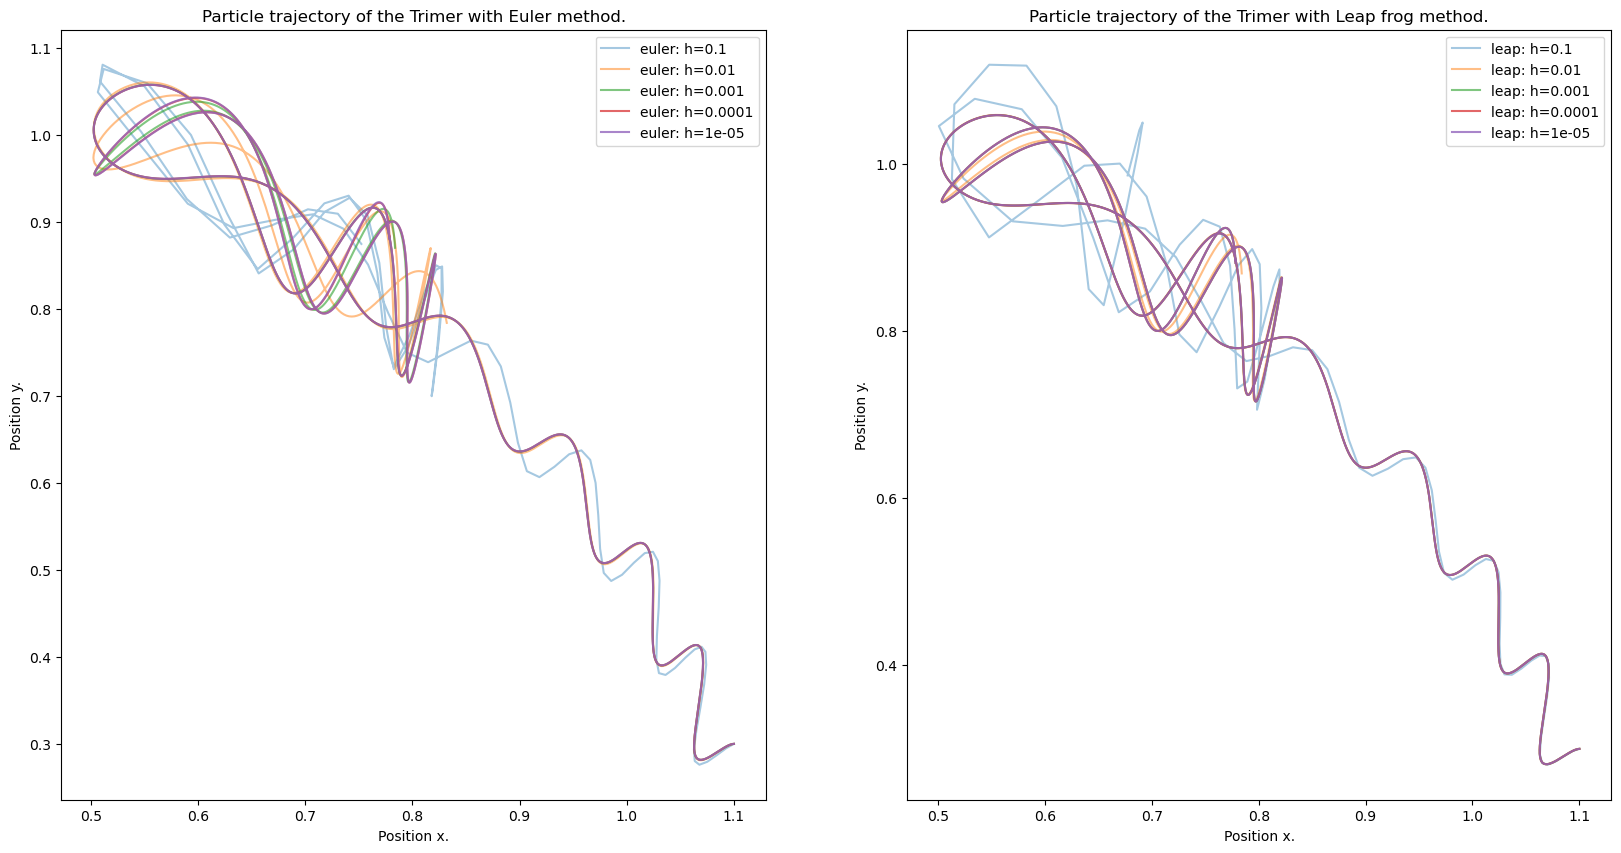

In [25]:
# IC for Test
q_ic = np.array([1.1,0.3]) # starting x,y
p_ic = np.array([-0.1,0])     # starting px,py
Ns = [10,100,1000,10000,100000]
hs = [1e-1,  1e-2,  1e-3, 1e-4, 1e-5]
max_time = 10
euler_sims_10s, leapfrog_sims_10s = run_sim(max_time,q_ic,p_ic, Ns, hs)
## plot results
fig1d,ax1d = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

for i,run in enumerate(euler_sims_10s):
    ax1d[0].plot( *run[0], alpha=(0.4+(0.1*i)), label=f'euler: h={hs[i]}')
ax1d[0].legend()
ax1d[0].set_xlabel('Position x.')
ax1d[0].set_ylabel('Position y.')
ax1d[0].set_title('Particle trajectory of the Trimer with Euler method.')

for i,run in enumerate(leapfrog_sims_10s):
    ax1d[1].plot( *run[0], alpha=(0.4+(0.1*i)),label=f'leap: h={hs[i]}')

ax1d[1].legend()
ax1d[1].set_xlabel('Position x.')
ax1d[1].set_ylabel('Position y.')
ax1d[1].set_title('Particle trajectory of the Trimer with Leap frog method.')
plt.show()


stage: 0 : Run time 0.008658170700073242
stage: 1 : Run time 0.006559610366821289
stage: 2 : Run time 0.048380136489868164
stage: 3 : Run time 0.4200749397277832
stage: 4 : Run time 2.3975670337677
stage: 5 : Run time 20.96207070350647
Elapsed time: 24.05032992362976 seconds


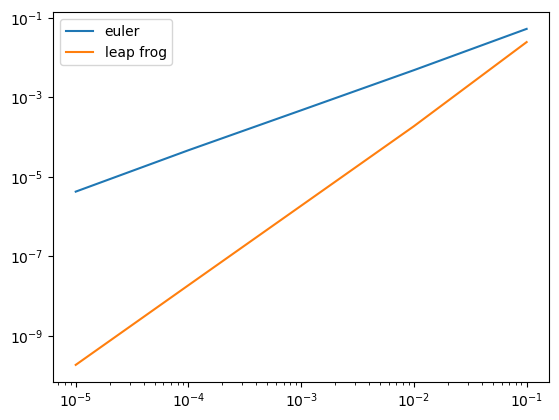

In [24]:
def global_error(q1, p1,q2,p2):  # Define the global error
    return np.linalg.norm( q1[:,-1] - q2[:,-1])

#compute error
# IC for Test
q_ic = np.array([1,1]) # starting x,y
p_ic = np.array([0,0])     # starting px,py
Ns = [10,100,1000,10000,100000,1000000]
hs = [1e-1,  1e-2,  1e-3, 1e-4, 1e-5,1e-6]
euler_sims_1s, leapfrog_sims_1s = run_sim(1,q_ic,p_ic, Ns, hs)
# Set memory
global_error_euler = np.zeros([len(Ns)-1])
global_error_leapfrog= np.zeros([len(Ns)-1])
for i in range(len(Ns)-1):
    global_error_euler[i] = global_error( *euler_sims_1s[i], *euler_sims_1s[-1])
    global_error_leapfrog[i] = global_error( *leapfrog_sims_1s[i], *leapfrog_sims_1s[-1])

# Plot error
plt.loglog( hs[:-1], global_error_euler, label="euler")
plt.loglog( hs[:-1], global_error_leapfrog, label="leap frog")
plt.legend()
plt.show()


<span style="color:blue">
Discussion:

The first key observation is that as the step size decreases, the error in both methods decreases as well, signifying a clear trend towards convergence. This aligns with the fundamental concept that smaller step sizes tend to yield more accurate results in numerical simulations.

The second noteworthy point pertains to the accuracy of the Leapfrog method, which exhibits a second-order accuracy property. This means that when the step size is reduced by a factor of $h$ the error decreases by a factor of $h^2$. This accuracy characteristic becomes evident when we analyse the slope of the line on the log-log graph, seeing that the leap frog method has slope of approximately 2 on log-log graph while euler methods has slope of approximately 1. 

As the step size decreases, the error decreases, indicating convergence. This behavior is consistent with the idea that smaller step sizes provide more accurate results.
The Leapfrog method exhibits second-order accuracy, which means that if the step size is reduced by a factor of $h$, the error decreases by a factor of $h^{2}$. This is evident from the slope of the line on the log-log graph.

This analysis highlights the importance of adjusting step sizes in numerical simulations to achieve the desired level of accuracy and convergence.
</span>

Implement an energy function, trimer_energy, which computes the energy as a function of q and p.  You should ideally design this function so that you can pass the trajectory (QQ,PP) to the function and have it compute the energies at all the steps.   Compare the energy growth against time for the two methods (Euler, leapfrog).  In this case you should **graph the energy** as a function of time for each trajectory.  You may choose much larger ending times than t=1, for example t=10, t=100 etc.  Perform enough runs using different stepsizes to gain a good understanding of the energy behavior of each method.   Briefly discuss the graphs.


In [26]:
def trimer_hamiltonian(q,p):
    # Set variables
    x = q[0]
    y = q[1]
    px = p[0]
    py = p[1]
    r = math.sqrt(x**2 + y**2)
    # compute the hamiltonian for the trimer
    return ( ((px**2)/4) + (9*(py**2))/4 + 2*phi_lj(r) + phi_lj( 2*x))

def trimer_energy(QQ,PP):
    # get size of QQ,PP
    N= np.shape(QQ)[1]
    # Allocate Memory.
    energy = np.zeros(N)
    for i in range(N):
        energy[i] = trimer_hamiltonian(QQ[:,i],PP[:,i])
    return energy
    
## Run for all
def compute_diff( euler_sims, leapfrog_sims):
    # Get the number of CPU cores on your system
    num_cores = os.cpu_count()
    with mp.Pool(processes=num_cores) as pool:
        #Compute energies for both euler and leap frog.
        euler_tmp = pool.apply_async(trimer_energy, args=euler_sims).get() 
        leapfrog_tmp = pool.apply_async(trimer_energy, args=leapfrog_sims).get() 

        # Array minus operation, taking the diff from first element for all elements in array
        euler_energy_diff = euler_tmp - euler_tmp[0] 
        leapfrog_energy_diff = leapfrog_tmp - leapfrog_tmp[0]
        
    return euler_energy_diff,leapfrog_energy_diff

stage: 0 : Run time 0.022893667221069336
Elapsed time: 0.20470213890075684 seconds
stage: 0 : Run time 0.01386570930480957
Elapsed time: 0.12833642959594727 seconds
stage: 0 : Run time 0.014900684356689453
Elapsed time: 0.13174915313720703 seconds
stage: 0 : Run time 0.013401985168457031
Elapsed time: 0.1275622844696045 seconds
stage: 0 : Run time 0.013551473617553711
Elapsed time: 0.20307350158691406 seconds
stage: 0 : Run time 0.01345062255859375
Elapsed time: 0.12639856338500977 seconds
stage: 0 : Run time 0.025755643844604492
Elapsed time: 0.16168642044067383 seconds
stage: 0 : Run time 0.013254404067993164
Elapsed time: 0.1223902702331543 seconds
stage: 0 : Run time 0.012852668762207031
Elapsed time: 0.1237955093383789 seconds
stage: 0 : Run time 0.01335000991821289
Elapsed time: 0.1247713565826416 seconds


Text(0.5, 1.0, 'Global Error against time for leap frog method h:[0.01]')

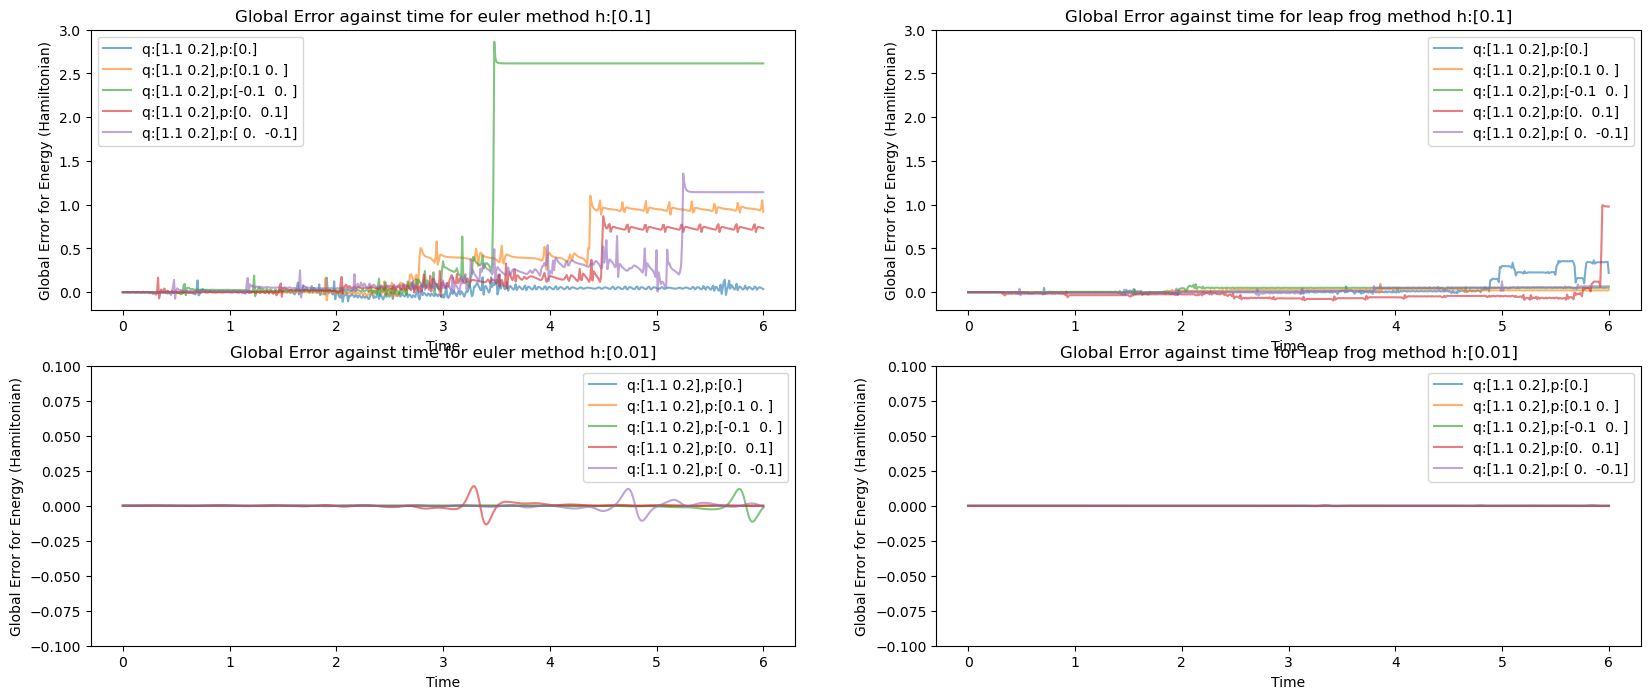

In [29]:
list_ic = [ (np.array([1.1,0.2]), np.array([0.0])),
            (np.array([1.1,0.2]), np.array([0.1,0])),
            (np.array([1.1,0.2]), np.array([-0.1,0])),
            (np.array([1.1,0.2]), np.array([0,0.1])),
            (np.array([1.1,0.2]), np.array([0,-0.1]))]
max_time = 6
Ns = [100]
hs = [1e-1]
euler_energy_diff_list = []
leapfrog_energy_diff_list = []     
for ic in list_ic:
    euler_run, leapfrog_run = run_sim(max_time, ic[0], ic[1], Ns, hs)
    euler_energy, leapfrog_energy =  compute_diff( euler_run[0], leapfrog_run[0])
    euler_energy_diff_list.append(euler_energy)
    leapfrog_energy_diff_list.append(leapfrog_energy)

fig1e,ax1e = plt.subplots(nrows=2, ncols=2, figsize=(20,8))


for i,energy in enumerate(euler_energy_diff_list):
    ax1e[0,0].plot(np.linspace(0,max_time, len(energy)), energy,alpha=0.6,label=f"q:{list_ic[i][0]},p:{list_ic[i][1]}")
ax1e[0,0].legend()
ax1e[0,0].set_xlabel('Time')
ax1e[0,0].set_ylabel('Global Error for Energy (Hamiltonian)')
ax1e[0,0].set_title(f'Global Error against time for euler method h:{hs}')
ax1e[0,0].set_ylim([-0.2,3])

for i,energy in enumerate(leapfrog_energy_diff_list):
    ax1e[0,1].plot(np.linspace(0,max_time, len(energy)), energy,alpha=0.6,label=f"q:{list_ic[i][0]},p:{list_ic[i][1]}")
ax1e[0,1].legend()
ax1e[0,1].set_xlabel('Time')
ax1e[0,1].set_ylabel('Global Error for Energy (Hamiltonian)')
ax1e[0,1].set_title(f'Global Error against time for leap frog method h:{hs}')
ax1e[0,1].set_ylim([-0.2,3])

# for next step size
Ns = [100]
hs = [1e-2]
euler_energy_diff_list = []
leapfrog_energy_diff_list = []     
for ic in list_ic:
    euler_run, leapfrog_run = run_sim(max_time, ic[0], ic[1], Ns, hs)
    euler_energy, leapfrog_energy =  compute_diff( euler_run[0], leapfrog_run[0])
    euler_energy_diff_list.append(euler_energy)
    leapfrog_energy_diff_list.append(leapfrog_energy)
    
for i,energy in enumerate(euler_energy_diff_list):
    ax1e[1,0].plot(np.linspace(0,max_time, len(energy)), energy,alpha=0.6,label=f"q:{list_ic[i][0]},p:{list_ic[i][1]}")
ax1e[1,0].legend()
ax1e[1,0].set_ylim([-0.1,0.1])
ax1e[1,0].legend()
ax1e[1,0].set_xlabel('Time')
ax1e[1,0].set_ylabel('Global Error for Energy (Hamiltonian)')
ax1e[1,0].set_title(f'Global Error against time for euler method h:{hs}')


for i,energy in enumerate(leapfrog_energy_diff_list):
    ax1e[1,1].plot(np.linspace(0,max_time, len(energy)), energy,alpha=0.6,label=f"q:{list_ic[i][0]},p:{list_ic[i][1]}")
ax1e[1,1].set_ylim([-0.1,0.1])
ax1e[1,1].legend()
ax1e[1,1].set_xlabel('Time')
ax1e[1,1].set_ylabel('Global Error for Energy (Hamiltonian)')
ax1e[1,1].set_title(f'Global Error against time for leap frog method h:{hs}')



<span style="color:blue">
Discussion:
In our observations, we notice that, when using an initial condition within a certain range, the Euler method with a step size of $h=0.1$ exhibits energy gain over time. This is evident from the increasing energy values as the simulation progresses. Such behavior is undesirable since the Hamiltonian's energy should ideally remain constant by definition. The substantial energy jumps can be attributed to model breakdown, specifically, instances where a particle escapes the oscillating setup.

On the other hand, the leapfrog method performs better than Euler, as it does not exhibit as significant an energy gain. However, it is worth noting that leapfrog, in some cases, still experiences breakdown.

Examination with a smaller step size of $h=0.01$, we find that both methods maintain a relatively constant energy level throughout the given time period. While the Euler method may still exhibit occasional energy fluctuations, they are less pronounced than with the larger step size.
</span>

# Twin Pendulum

In this exercise you will modify the python code to compute solutions of a system of two particles moving in the plane. The particles will each be connected to the origin by a spring with rest length.  The particles also interact in a spring potential.

We think of our position vector $q$ as holding the position data for the whole system, so $q=[q_1,q_2]=[q_{1,x},q_{1,y},q_{2,x},q_{2,y}]$, and, similarly, $p$ is a vector in $\bf{R}^4$. We can write the new energy function as $$ H(q,p) = \| p_1 \|^2/2 + \| p_2 \|^2/2 + \omega_1^2(\|q_1\|-1)^2+ \omega_2^2(\|q_2\|-1)^2 + \epsilon \|q_1-q_2\|^2/2$$
Here $\omega_1,\omega_2$ are the frequencies of two nonlinear oscillators and $eps$ is the coupling coefficient.

Define new functions  `twinpend_energy` and `twinpend_force` using the trimer functions as models.  You do not need to compare the Euler and leapfrog methods in this example, **just use the leapfrog scheme.**

In [2]:
norm =np.linalg.norm
sqrt = math.sqrt
def twinpend_energy(q,p, omega1, omega2, epsilon): # q,p [2,2] = [[ x1,y1],[x2,y2]]
    q1 = q[0:2]
    p1 = p[0:2]
    q2 = q[2:4]
    p2 = p[2:4]
    return ( norm(p1)**2)/2 + (norm(p2)**2)/2 + (omega1**2)* (( norm(q1) -1)**2)+(omega2**2)* (( norm(q2) -1)**2) + (epsilon/2)*(norm(q1-q2)**2)
    
def twinpend_force(q, omega1, omega2, epsilon):
    q1_x,q1_y = q[0:2]
    q2_x,q2_y = q[2:4]
    qq1 = ( norm(q[0:2])-1) / norm(q[0:2])
    qq2 = ( norm(q[2:4])-1) / norm(q[2:4])
    
    dq1_x = (2)*(omega1**2)*( q1_x * qq1) + epsilon*(q1_x -q2_x)
    dq1_y = (2)*(omega1**2)*( q1_y * qq1) + epsilon*(q1_y -q2_y)
    dq2_x = (2)*(omega1**2)*( q2_x * qq2) - epsilon*(q1_x -q2_x)
    dq2_y = (2)*(omega1**2)*( q2_y * qq2) - epsilon*(q1_y -q2_y)
    return np.array([ -dq1_x , -dq1_y , -dq2_x , -dq2_y])

Set the constants $\omega_1,\omega_2$ equal to one.  Set $\epsilon=0.1$ to represent a moderate coupling.  Take as initial condition $q_0 = [0,1,0,1]^T$ and $p_0 = [1,-1,1,1]^T$.  You will need to experiment a little: choose the stepsize by trial and error to get an accurate approximation of the true motion, but bear in mind the need to use a relatively large stepsize (e.g. $h=0.1$) in order to compute a reasonably long-term evolution of the system. Plot the trajectories of the two particles in the $(x,y)$ plane, on the same axes, with a separate curve for each particle.  Separately, plot the energy as a function of time.  

Text(0.5, 1.0, 'Energy of the Twin Pendulum against time.')

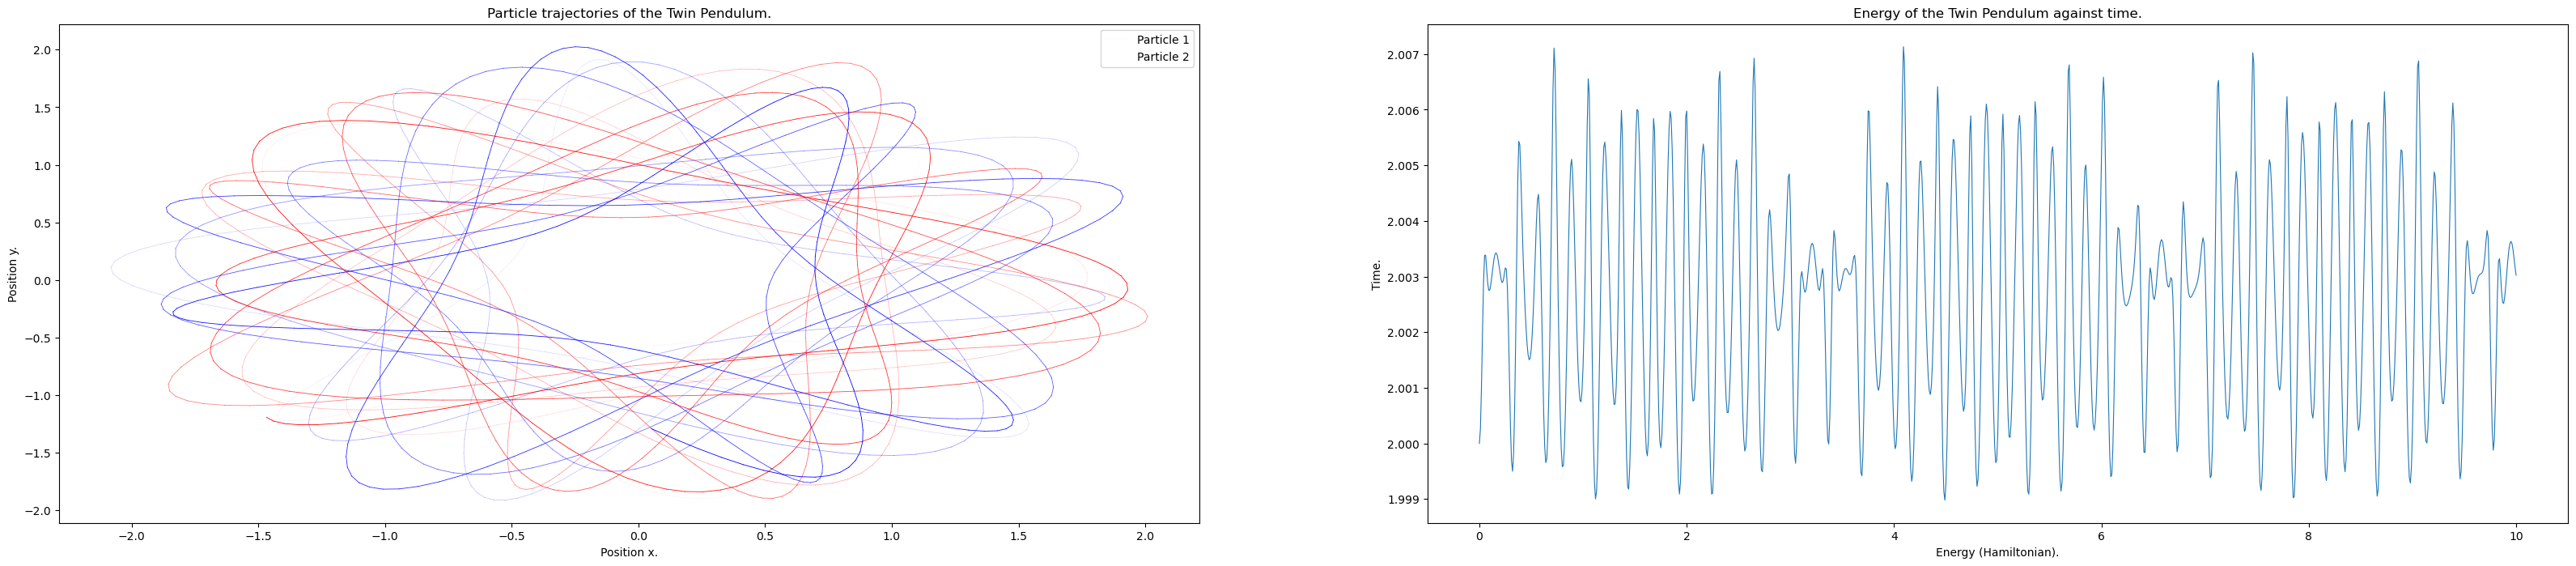

In [3]:

def twinpend_energies(Q,P, omega1, omega2, epsilon):
    n = Q.shape[1]
    energies = np.zeros(n)
    for i in range(n):
        energies[i] = twinpend_energy( Q[:,i], P[:,i], omega1, omega2, epsilon)
    return energies

def leap_frog_step(q,p,h, omega1, omega2, epsilon):
    q_copy = np.copy(q)
    p_copy =np.copy(p)
    # half step
    p_half = p_copy + (1/2) * h * twinpend_force(q_copy, omega1, omega2, epsilon)
    # update q
    q_copy = q_copy + h * p_half
    # update p
    p_copy = p_half + (1/2)* h * twinpend_force(q_copy, omega1, omega2, epsilon)
    return q_copy, p_copy

def compute_trajectory(q0, p0, h, Ns, omega1, omega2, epsilon):
    q = np.copy(q0)
    p = np.copy(p0)
    # allocate memory.
    Q = np.zeros( (4, int(Ns+1)) ) # Q = [[ x1,y1,x2,y2], ... ] 
    P = np.zeros( (4, int(Ns+1)) )
    # Set IC
    Q[:,0] = q
    P[:,0] = p
    for i in range(1, Ns+1):
        q,p = leap_frog_step(q,p,h,omega1, omega2, epsilon)
        Q[:,i] = q
        P[:,i] = p
    return Q,P

omega1 = 1
omega2 = 1
epsilon =0.1
q0 = np.array([0,1,0,1])
p0 = np.array([1,-1,1,1])
h=0.1
N=1000
Q,P = compute_trajectory( q0, p0, h, N, omega1, omega2, epsilon)
twin_pend_energies = twinpend_energies( Q,P, omega1, omega2, epsilon)

# Plot results:

fig2b,axes2b = plt.subplots(nrows=1, ncols=2, figsize=(40,8))
# to create time based faded line
for i in range(N-1):
    alpha = (1/ (N-1))*i
    color_p1 = (0, 0, 1, alpha)
    color_p2 = (1, 0, 0, alpha)
    axes2b[0].plot(Q[0,i:i+2],Q[1,i:i+2], color=color_p1, linewidth=0.6)
    axes2b[0].plot(Q[2,i:i+2],Q[3,i:i+2], color=color_p2, linewidth=0.6)
#axes2b[0].plot(Q[0,:],Q[1,:], alpha =0.7, linewidth=0.3, label='Particle 1') # p1
#axes2b[0].plot(Q[2,:],Q[3,:], alpha =0.7, linewidth=0.3, label='Particle 2') # p2
axes2b[0].plot(0,0, color=color_p1, linewidth=0.01, label='Particle 1')
axes2b[0].plot(0.0, color=color_p2, linewidth=0.01, label='Particle 2')

axes2b[0].set_xlabel('Position x.')
axes2b[0].set_ylabel('Position y.')
axes2b[0].set_title('Particle trajectories of the Twin Pendulum.')
axes2b[0].legend()
# Energy plot
axes2b[1].plot(np.linspace(0,1000/100, 1000+1), twin_pend_energies, linewidth=0.8)
axes2b[1].set_xlabel('Energy (Hamiltonian).')
axes2b[1].set_ylabel('Time.')
axes2b[1].set_title('Energy of the Twin Pendulum against time.')



**Exercise 2c - evaluation and discussion [8]:**
Using graphs and text, explore the motion of the twin pendulum system.    
Are the solutions periodic?  Bounded?  Is this  a chaotic dynamical system?  
Conduct further experiments to understand the system: what happens when you start them with different intial conditions?  With high velocities?  How does the choice of stepsize alter the behavior you observe?   Your answer for this part should comprise about one paragraph  (at most around 250 words) of English text, with a few graphs, all incorporated as markup in your jupyter notebook.

In [4]:
def run_sim_twin_pend(omega1, omega2, epsilon, q0, p0, h, N, plot_label):
    Q,P = compute_trajectory( q0, p0, h, N, omega1, omega2, epsilon)
    twin_pend_energies = twinpend_energies( Q,P, omega1, omega2, epsilon)

    # Plot results:
    fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
    # to create time based faded line
    for i in range(N-1):
        alpha = (1/ (N-1))*i
        color_p1 = (0, 0, 1, alpha)
        color_p2 = (1, 0, 0, alpha)
        ax.plot(Q[0,i:i+2],Q[1,i:i+2], color=color_p1, linewidth=0.6)
        ax.plot(Q[2,i:i+2],Q[3,i:i+2], color=color_p2, linewidth=0.6)
    #axes2b[0].plot(Q[0,:],Q[1,:], alpha =0.7, linewidth=0.3, label='Particle 1') # p1
    #axes2b[0].plot(Q[2,:],Q[3,:], alpha =0.7, linewidth=0.3, label='Particle 2') # p2
    ax.plot([0,0],[0,0], color=color_p1, linewidth=0.7, label='Particle 1')
    ax.plot([0,0],[0,0], color=color_p2, linewidth=0.7, label='Particle 2')

    ax.set_xlabel('Position x.')
    ax.set_ylabel('Position y.')
    ax.set_title('Particle trajectories'+plot_label)
    ax.legend()

<span style="color:blue">

# Periodicity:

The solutions of the twin pendulum system are not strictly periodic. While they do exhibit some periodic behavior, this periodicity is not exact due to the nonlinearity in the system. However, when the coupling coefficient $\epsilon$ is set to zero, the system becomes periodic. You can see this in the plot below, where the system's motion is more regular.

</span>

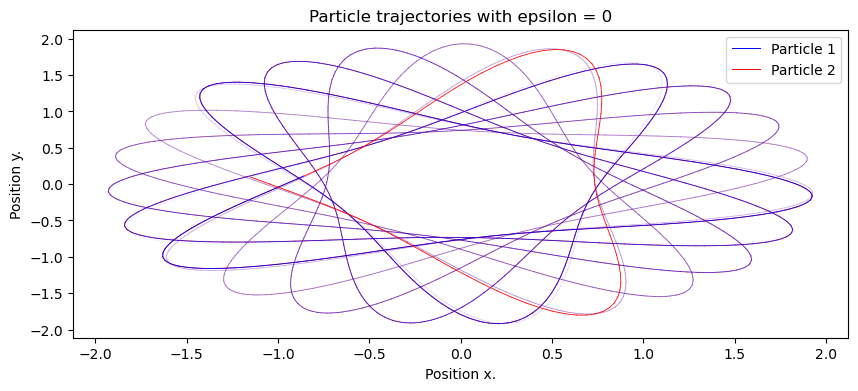

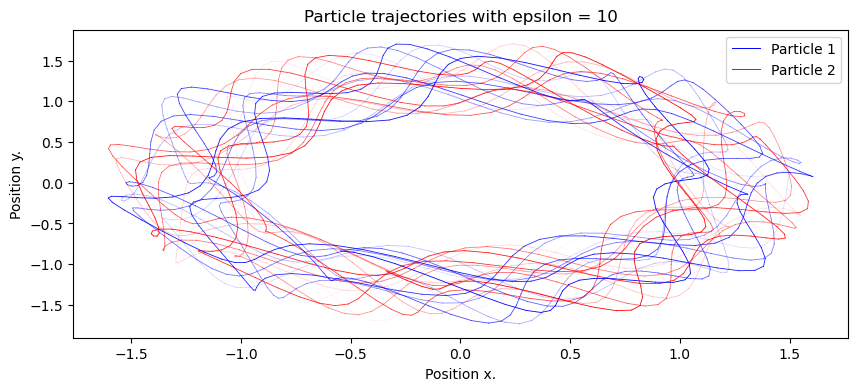

In [9]:
q0 = np.array([0,1,0,1])
p0 = np.array([1,-1,1,1])
run_sim_twin_pend(1,1,0, q0, p0, 0.1, 1000, ' with epsilon = 0')
run_sim_twin_pend(1,1,10, q0, p0, 0.1, 1000, ' with epsilon = 10')

<span style="color:blue">
    
# Boundedness:
    
The twin pendulum system is bounded within a finite region of the phase space.
</span>

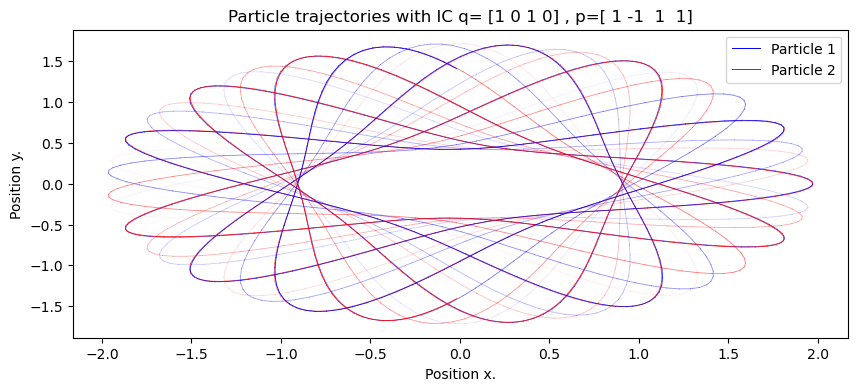

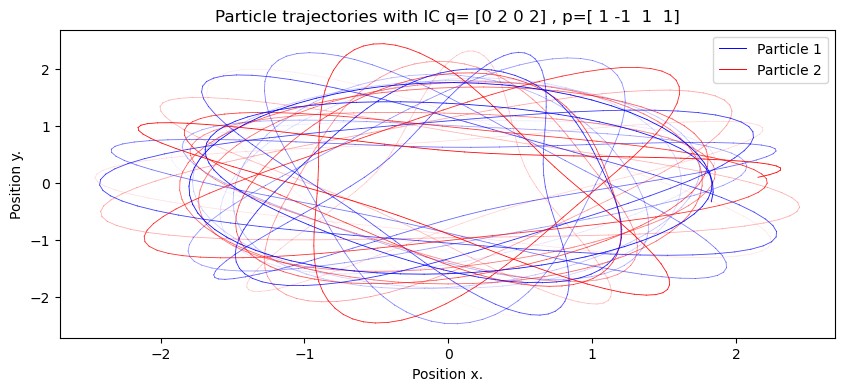

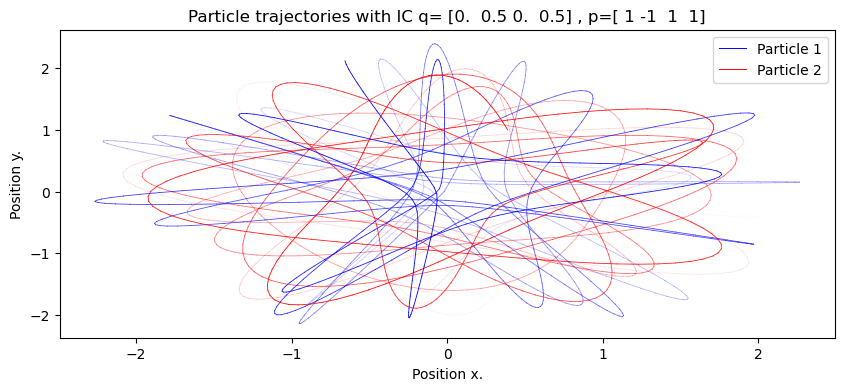

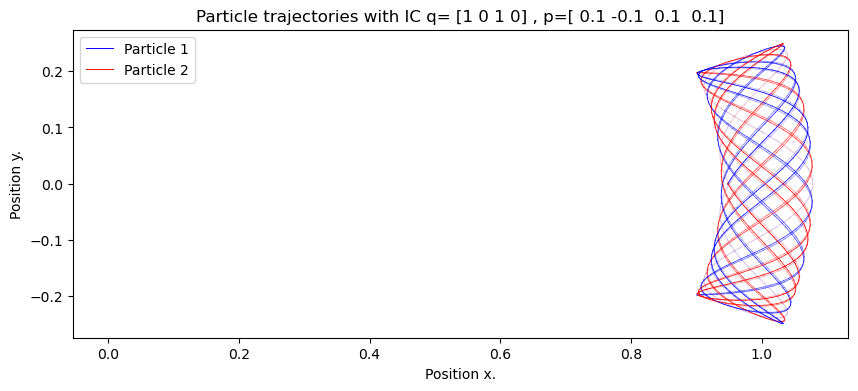

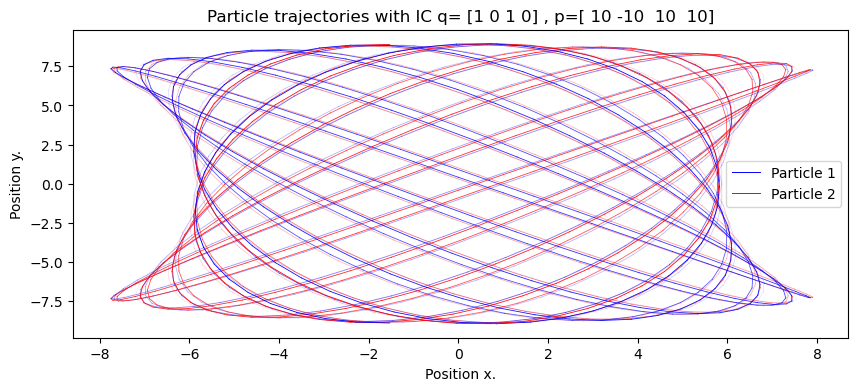

In [12]:
q0 = np.array([1,0,1,0])
p0 = np.array([1,-1,1,1])
run_sim_twin_pend(1,1,0.1, q0, p0, 0.1, 1000, f' with IC q= {q0} , p={p0}')
q0 = np.array([0,2,0,2])
p0 = np.array([1,-1,1,1])
run_sim_twin_pend(1,1,0.1, q0, p0, 0.1, 1000, f' with IC q= {q0} , p={p0}')
q0 = np.array([0,0.5,0,0.5])
p0 = np.array([1,-1,1,1])
run_sim_twin_pend(1,1,0.1, q0, p0, 0.1, 1000, f' with IC q= {q0} , p={p0}')
q0 = np.array([1,0,1,0])
p0 = np.array([0.1,-0.1,0.1,0.1])
run_sim_twin_pend(1,1,0.1, q0, p0, 0.1, 1000, f' with IC q= {q0} , p={p0}')
q0 = np.array([1,0,1,0])
p0 = np.array([10,-10,10,10])
run_sim_twin_pend(1,1,0.1, q0, p0, 0.1, 1000, f' with IC q= {q0} , p={p0}')

<span style="color:blue">

# Chaotic Dynamics: 

The twin pendulum system is indeed a chaotic dynamical system. Chaos in this context is characterised by its sensitivity to initial conditions. Even small changes in the initial positions and momenta of the particles can lead to significantly different trajectories over time. This sensitivity to initial conditions can be observed in the following experiments:

In the first run, with initial conditions p1 = [0, 0.33] and p2 = [0, 0.33], you observe a particular solution for the particle trajectories.
In the second run, when the initial conditions are slightly altered to p1 = [0, 1/3] and p2 = [0, 1/3], the system's behavior diverges from the previous run, resulting in a different trajectory.
This sensitivity to initial conditions is a typical of chaos and highlights the complexity of the twin pendulum system.
</span>

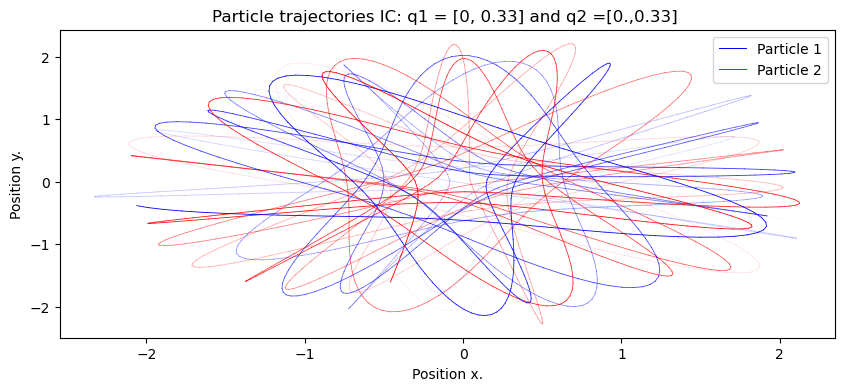

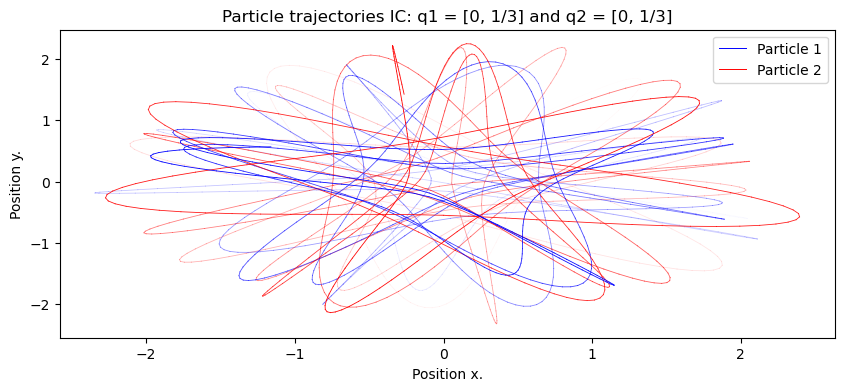

In [15]:
q0 = np.array([0,0.33,0,0.33])
p0 = np.array([1,-1,1,1])
run_sim_twin_pend(1,1,0.1, q0, p0, 0.1, 1000, f' IC: q1 = [0, 0.33] and q2 =[0.,0.33] ')
q0 = np.array([0,1/3,0,1/3])
p0 = np.array([1,-1,1,1])
run_sim_twin_pend(1,1,0.1, q0, p0, 0.1, 1000, f' IC: q1 = [0, 1/3] and q2 = [0, 1/3]')

In this exercise you will explore the conservation of total energy and the exchange of energy between two coupled pendula.  This related to the concept of adiabatic separation which plays an important role in physical models.

Define two energies by $E_1 = \| p_1 \|^2/2 + \omega_1^2(\|q_1\|-1)^2$ and $E_2 = \| p_2 \|^2/2 + \omega_2^2(\|q_2\|-1)^2$. Note that the total energy in the twin pendulum system is the sum of $E_1$ and $E_2$ plus the coupling term $\epsilon \|q_1-q_2\|^2/2$.  Create a function that takes QQ and PP and outputs arrays $E_1$, $E_2$ and $E$ which contain the corresponding energies at each step.

Set $\omega_1=\omega_2=1$ and $\epsilon =.1$.   Starting with the initial condition $q_0 = [0,-1,0,-1]^T$, $p_0 =[10,1,0,0]^T$, compute trajectories of the system and graph the trajectories in the $xy$-plane (separate curves for each particle). Use a stepsize $h=0.01$ and integrate for 1e5 steps.  Separately, plot the energies $E_1$ and $E_2$ over time.  Clearly the first subsystem starts with a higher initial energy than the second one ($E_1>>E_2$), but you should see that the energy gets exchanged rapidly between the two systems.  Despite this, you should also see that the total energy is well conserved, even when the time interval is fairly long.

Now consider the behavior of the system as $h$ is changed from $h=0.01$ to $h=0.1$, with all other parameters the same as before (N=1e5 steps).  (You can explore what happens when N is increased even further, if your computer is powerful enough!)  You should observe that the energy is no longer well conserved.  How does the total energy conservation depend on the stepsize, all other things being constant?

Try decreasing $\epsilon$ to 0.01 (reducing the strength of the coupling) and repeat your tests.    How does the strength of the coupling effect the results?

You may wish to explore what happens as you make the second frequency larger: $\omega_2=10$.

Your answer to this exercise should be around 500 words, maximum, supplemented by a few graphs.

In [30]:
def compute_energies(q,p, omega1,omega2,epsilon):
    E1 = (1/2) *( norm(p[0:2])**2 ) + ( omega1 **2) * (( norm(q[0:2])-1)**2)
    E2 = (1/2) *( norm(p[2:4])**2 ) + ( omega2 **2) * (( norm(q[2:4])-1)**2)
    coupling_term = epsilon* ( norm(q[0:2] - q[2:4])**2) / 2
    E = E1 + E2 + coupling_term
    return E,E1,E2,coupling_term
    
def twinpend_energies_breakdown(Q,P, omega1, omega2, epsilon):
    n = Q.shape[1]
    energies = np.zeros((4,n))
    for i in range(n):
        energies[:,i] = compute_energies( Q[:,i], P[:,i], omega1, omega2, epsilon)
    return energies

def run_sim_plot_energy(omega1, omega2, epsilon, q0, p0, h, N):
    Q,P = compute_trajectory( q0, p0, h, N, omega1, omega2, epsilon)
    E,E1,E2,coupling_term = twinpend_energies_breakdown( Q,P, omega1, omega2, epsilon)
    return (Q,P,E,E1,E2,coupling_term)
    
def plot_sim_energy( Q,P,E,E1,E2,coupling_term, h, N,plot_label):
    # Plot results:
    fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(10,8))
    # to create time based faded line
    for i in range(N-1):
        alpha = (1/ (N-1))*i
        color_p1 = (0, 0, 1, alpha)
        color_p2 = (1, 0, 0, alpha)
        ax[0].plot(Q[0,i:i+2],Q[1,i:i+2], color=color_p1, linewidth=0.6)
        ax[0].plot(Q[2,i:i+2],Q[3,i:i+2], color=color_p2, linewidth=0.6)
    ax[0].plot([0,0],[0,0], color=color_p1, linewidth=0.7, label='Particle 1')
    ax[0].plot([0,0],[0,0], color=color_p2, linewidth=0.7, label='Particle 2')
    ax[0].set_xlabel('Position x.')
    ax[0].set_ylabel('Position y.')
    ax[0].set_title('Particle trajectories'+plot_label)
    ax[0].legend()
    # plot energy
    time_step_x_axis = np.linspace(0, N/h, N+1)
    ax[1].plot(time_step_x_axis, E, alpha=0.9, label='Total energy',linewidth=0.6)
    ax[1].plot(time_step_x_axis, E1, alpha=0.7, label='E1',linewidth=0.6)
    ax[1].plot(time_step_x_axis, E2,alpha=0.7, label='E2',linewidth=0.6)
    ax[1].plot(time_step_x_axis, coupling_term,alpha=0.4, label='Coupling term energy',linewidth=0.6)
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Energy')
    ax[1].set_title('Energies of Twin Pendulum Subsystems'+plot_label)
    ax[1].legend()


<span style="color:blue">
# Effect of Step Size: 

In the initial simulation with $h_{0}=0.01$ we observe that the energies $E_{1}$​ and $E_{2}$​ fluctuate but are relatively well conserved, despite the rapid exchange of energy between the two particles. This is due to the relatively small step size that captures the dynamics accurately. However, the total energy $E_{T}$ remains conserved over a longer time interval. When we increase the step size to and $h_{1}=0.1$, we observe that the energy is no longer well conserved. The larger step size causes significant numerical errors, leading to energy dissipation.

</span>

/usr/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


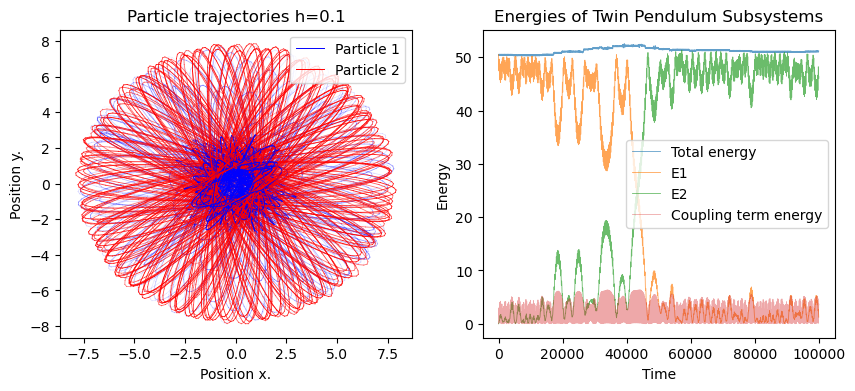

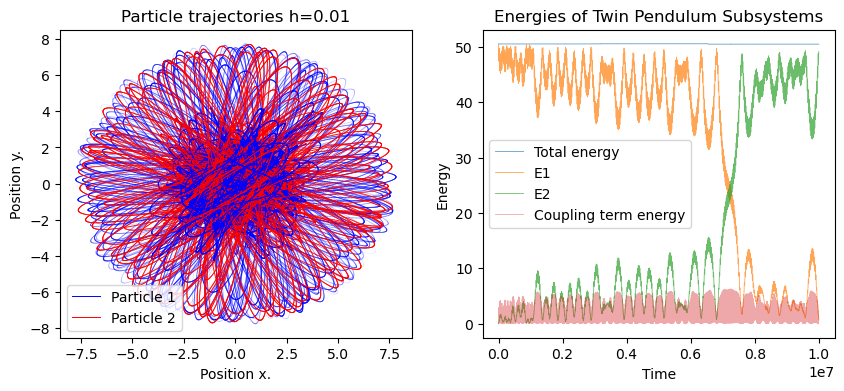

In [6]:
# Define the parameters
omega1 = 1
omega2 = 1
epsilon = 0.1
# Initial conditions
q0 = np.array([0, -1, 0, -1])
p0 = np.array([10, 1, 0, 0])

Ns1 = int(1e4)
Ns2 = int(1e4)*10
h1   = 0.1
h2  = 0.01


# Simulate the system
# Get the number of CPU cores on your system
num_cores = os.cpu_count()
with mp.Pool(processes=num_cores) as pool:
    sim_h01_tmp   = pool.apply_async(run_sim_plot_energy, args=(omega1,omega2,epsilon, q0, p0, h1, Ns1))
    sim_h001_tmp  = pool.apply_async(run_sim_plot_energy, args=(omega1,omega2,epsilon, q0, p0, h2, Ns2))

    sim_h01   = sim_h01_tmp.get()
    sim_h001  = sim_h001_tmp.get()

plot_sim_energy(*sim_h01, h1, Ns1, f' h={h1}')
plot_sim_energy(*sim_h001, h2, Ns2, f' h={h2}')

<span style="color:blue">
# Effect of Coupling Strength: 

In the following cell, we adjust the coupling strength $\epsilon$ between the two particles. When reducing $\epsilon$ to 0.01, we weaken the interaction between the two particles. With weaker coupling, the exchange of energy between $E_{1}$ and $E_{2}$ particles becomes less significant, resulting in better conservation of the total energy. This can be observed through the relatively flat energy plots compared to the plot of the first graph where $\epsilon = 0.1$.

Conversely, when we increase the coupling strength to $\epsilon = 0.9$, we observe the opposite effect. Energy is transferred more frequently between $E_{1}$ and $E_{2}$, leading to less conservation of the total energy compared to the other cases.
</span>

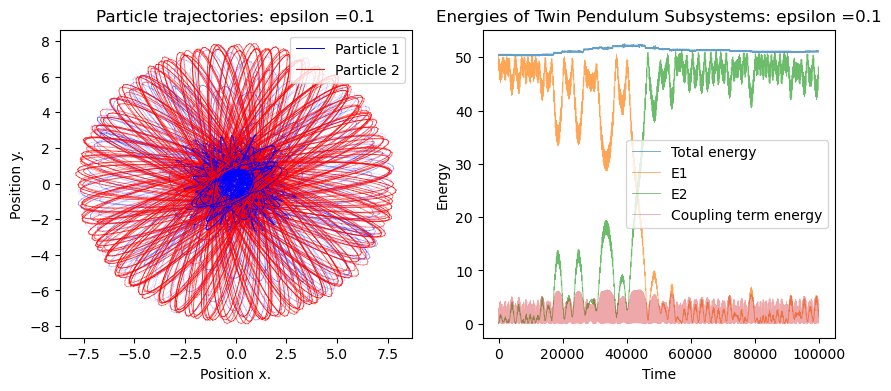

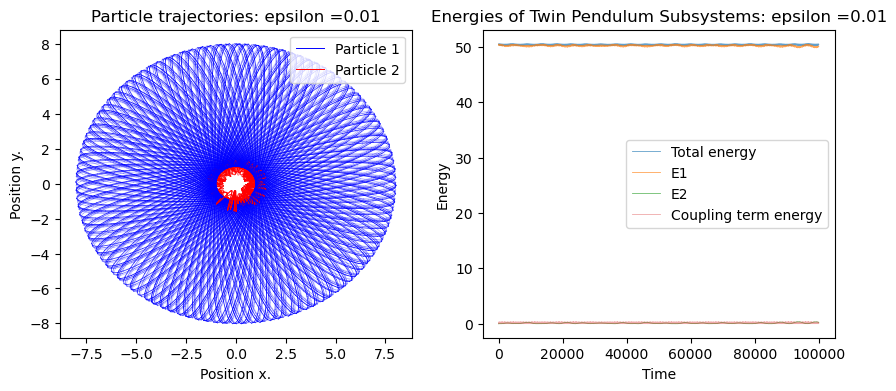

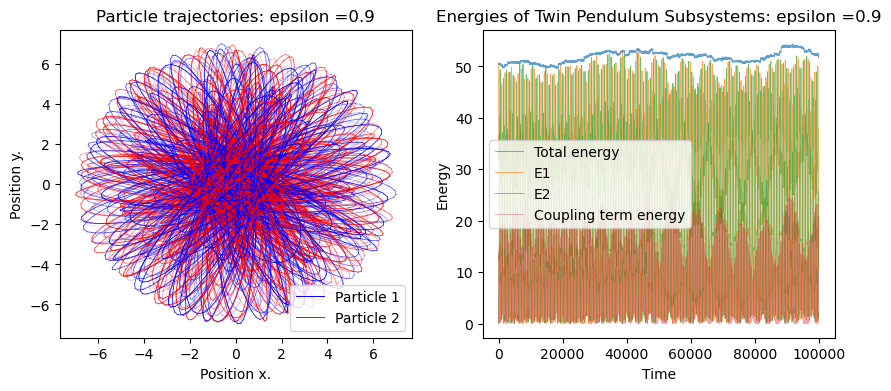

In [9]:
# Define the parameters
omega1 = 1
omega2 = 1
epsilon1 = 0.1
epsilon2 = 0.01
epsilon3 = 0.9

# Initial conditions
q0 = np.array([0, -1, 0, -1])
p0 = np.array([10, 1, 0, 0])

Ns = int(1e4) # My laptop struggles with large data sets with python.
h01   = 0.1


# Simulate the system
# Get the number of CPU cores on your system
num_cores = os.cpu_count()
with mp.Pool(processes=num_cores) as pool:
    sim_1   = pool.apply_async(run_sim_plot_energy, args=(omega1,omega2,epsilon1, q0, p0, h01, Ns))
    sim_2   = pool.apply_async(run_sim_plot_energy, args=(omega1,omega2,epsilon2, q0, p0, h01, Ns))
    sim_3   = pool.apply_async(run_sim_plot_energy, args=(omega1,omega2,epsilon3, q0, p0, h01, Ns))


    sim_1   = sim_1.get()
    sim_2   = sim_2.get()
    sim_3   = sim_3.get()


plot_sim_energy(*sim_1, h01, Ns, f': epsilon ={epsilon1}')
plot_sim_energy(*sim_2, h01, Ns, f': epsilon ={epsilon2}')
plot_sim_energy(*sim_3, h01, Ns, f': epsilon ={epsilon3}')

<span style="color:blue">
# Larger Frequency for the Second Pendulum:

In the following cell, we adjust the frequency parameter $\omega_1$ while keeping other parameters constant. By increasing the frequency to $\omega_1 = 2$, we observe that there is no energy exchange between the two particles in the system. This is evident in the constant flat lines in the plots for both $E_{1}$ and $E_{2}$, signifying that the system conserves energy. Furthermore, in the vector plot, it becomes apparent that particle 1 dominates the space, indicating its more extensive movement compared to particle 2. This dominance is also reflected in the energy plots, where $E_{1}$ significantly surpasses $E_{2}$. This behavior is in contrast to the initial plot with $\omega_{1} = \omega_{2} = 1$, where particle 2 dominates the vector plot. In this case, we observe a significant energy exchange between $E_{1}$ and $E_{2}$, causing this behavior.

In the final plot, we test this analysis by changing $\omega_{1} = 1$ and setting $\omega_{2} = 2$. Consequently, particle 2 eventually dominates the vector plot. However, it is important to note that in this scenario, the model breaks down due to the system gaining an increase in total energy $E_{T}$.

</span>

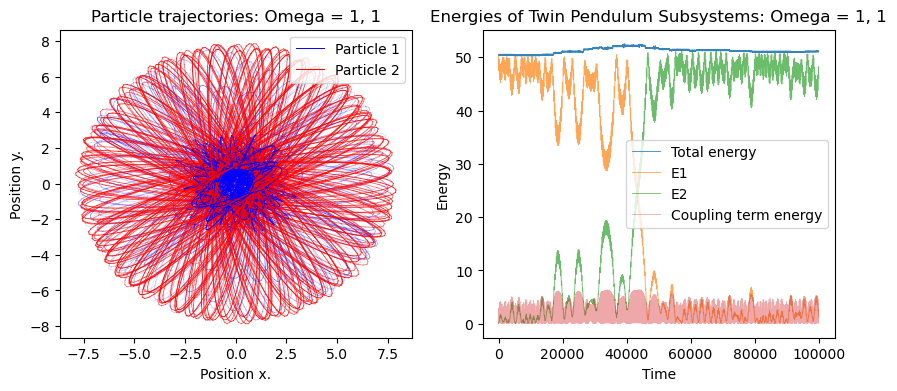

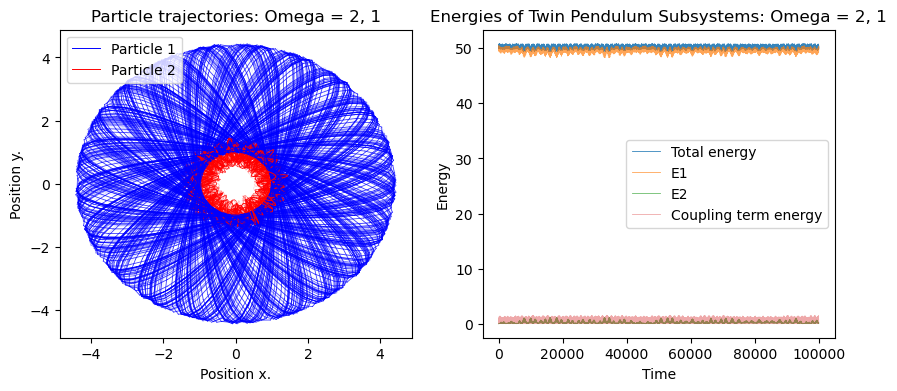

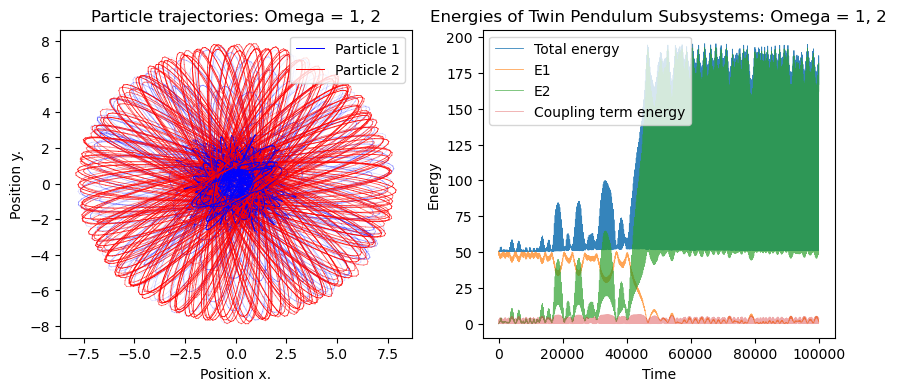

In [13]:
# Define the parameters
omega1_1 = 1
omega2_1 = 1
omega1_2 = 2
omega2_2 = 1
omega1_3 = 1
omega2_3 = 2
epsilon = 0.1
# Initial conditions
q0 = np.array([0, -1, 0, -1])
p0 = np.array([10, 1, 0, 0])

Ns = int(1e4)
h   = 0.1


# Simulate the system
# Get the number of CPU cores on your system
num_cores = os.cpu_count()
with mp.Pool(processes=num_cores) as pool:
    sim_1   = pool.apply_async(run_sim_plot_energy, args=(omega1_1,omega2_1,epsilon, q0, p0, h, Ns))
    sim_2   = pool.apply_async(run_sim_plot_energy, args=(omega1_2,omega2_2,epsilon, q0, p0, h, Ns))
    sim_3   = pool.apply_async(run_sim_plot_energy, args=(omega1_3,omega2_3,epsilon, q0, p0, h, Ns))

    sim_1   = sim_1.get()
    sim_2   = sim_2.get()
    sim_3   = sim_3.get()


plot_sim_energy(*sim_1, h, Ns, f': Omega = {omega1_1}, {omega2_1}')
plot_sim_energy(*sim_2, h, Ns, f': Omega = {omega1_2}, {omega2_2}')
plot_sim_energy(*sim_3, h, Ns, f': Omega = {omega1_3}, {omega2_3}')